<a href="https://colab.research.google.com/github/DavideRutigliano/ANNDL/blob/master/Challenge_1_%5BEfficientNet_B4_re_trained_99_%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install useful packages

We install ```tensorflow-gpu==1.14.0``` as kaggle does not have the right cudNN drivers installed in kernels; anyway if changing to ```tensorflow-gpu==2.0.0``` and running the notebook on colab tensorflow 2.0 correctly works. Using tensorflow 2.0 could speed-up the training process as it allows to use mixed precision (i.e. using ```float16``` instead of ```float32``` ```dtypes```, except for the very last layer of the NN softmax/sigmoid/... for numerical stability).

 

In [0]:
%%capture

!pip install tensorflow-gpu==1.14.0
#2.0.0
!pip install efficientnet
!pip uninstall -y imgaug
!pip install imgaug

In [0]:
%%capture

!pip uninstall -y kaggle
!pip install kaggle

## Download competition dataset

In [0]:
import os

In [4]:
os.environ["KAGGLE_USERNAME"] = "lazcoder"
os.environ["KAGGLE_KEY"] = "fa7b43829e399f7c41444b5ed1be3afd"

raw_data_dir = "input/raw"
!rm -r {raw_data_dir}
!kaggle competitions download -c ann-and-dl-image-classification -p {raw_data_dir}

rm: cannot remove 'input/raw': No such file or directory
 89% 81.0M/90.5M [00:01<00:00, 62.3MB/s]
100% 90.5M/90.5M [00:01<00:00, 76.8MB/s]


In [0]:
%%capture

!apt-get install fuse-zip

In [0]:
%%capture

input_dir = "../input/ann-and-dl-image-classification/"

!mkdir ../input
!mkdir ../input/ann-and-dl-image-classification

!fuse-zip {raw_data_dir}/ann-and-dl-image-classification.zip {input_dir}

In [7]:
!ls {input_dir}/Classification_Dataset
#!rm -r {input_dir}/Classification_Dataset

test  training


## Import useful libraries

In [0]:
%%capture

import os
import multiprocessing as mp
import gc

import numpy as np
np.random.seed(1234)

import pandas as pd

import cv2

import imgaug as ia
ia.seed(1234)
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.utils import shuffle as sklearn_shuffle
from sklearn.model_selection import train_test_split

#try:
#    %tensorflow_version 2.x
#except:
#    pass

#%tensorflow_version 1.x

import tensorflow as tf

from efficientnet.tfkeras import EfficientNetB4

In [9]:
print("Tensorflow version:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    gpu = gpus[0]
    print("Using GPU(s):", gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    #if tf.__version__ == '2.0.0':
    #    tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
    # NOTE: needs for input_shape to have channels_first to be effective
    #    tf.keras.backend.set_image_data_format('channels_first')
else:
    print("Not using GPU")

Tensorflow version: 1.14.0
Using GPU(s): PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load and Visualize Data

In [0]:
input_dir = "../input/ann-and-dl-image-classification/Classification_Dataset/"
train_dir = input_dir + "training/"

classes = [
    'owl',
    'galaxy',
    'lightning',
    'wine-bottle',
    't-shirt',
    'waterfall',
    'sword',
    'school-bus',
    'calculator',
    'sheet-music',
    'airplanes',
    'lightbulb',
    'skyscraper',
    'mountain-bike',
    'fireworks',
    'computer-monitor',
    'bear',
    'grand-piano',
    'kangaroo',
    'laptop'
]

n_classes = len(classes)

In [0]:
def load_data(label_names,
              directory):
  
    images = []
    labels = []
    filenames = []

    for folder in os.listdir(directory):
        curr_label = label_names.index(folder)

        for file in os.listdir(directory + "/" + folder):
            filenames.append(file)
            img_path = directory + "/" + folder + "/" + file
            curr_img = cv2.imread(img_path)
            images.append(curr_img)
            labels.append(curr_label)

    images = np.array(images) 
    labels = np.array(labels) 
    filenames = np.array(filenames) 

    return (images, labels, filenames)

In [12]:
(X, y, filenames) = load_data(classes, train_dir)

print("Training data:", X.shape[0])

Training data: 1554


### Dataset split

We decided to split the training dataset in $70\%$ training and $30\%$ validation, shuffling the data and trying to get the same distribution of data for both sets.

We decided for a validation set of $30\%$ of the original training set as it will result in around 450 images (against 500 of the test set), leaving around 1100 images for training. With original images and augmentation with factor $2\times$ we get around 3300 samples that seems enough for training the model (as we use as convolutional base a pretrained model) still giving validation results that reflects test ones.


In [13]:
X, X_val, \
y, y_val, \
filenames_train, filenames_val = train_test_split(X, y, filenames,
                                                  test_size=.3,
                                                  stratify=y,
                                                  shuffle=True,
                                                  random_state=1234)

print("Training data (after split):", X.shape[0])
print("Validation data:", X_val.shape[0])

Training data (after split): 1087
Validation data: 467


In [0]:
dataset_split = {
    "training" : {},
    "validation" : {}
}

for c in classes:
    dataset_split["training"][c] = []
    dataset_split["validation"][c] = []

for idx in range(len(X)):
    dataset_split["training"][classes[y[idx]]]\
        .append(filenames_train[idx])

for idx in range(len(X_val)):
    dataset_split["validation"][classes[y_val[idx]]]\
        .append(filenames_val[idx])

import json

filename = 'dataset_split.json'

with open(filename, 'w') as fp:
    json.dump(dataset_split, fp)

#with open(filename) as infile:
#    data = json.load(infile)

#pd.DataFrame(dataset_split)

### Plot some images

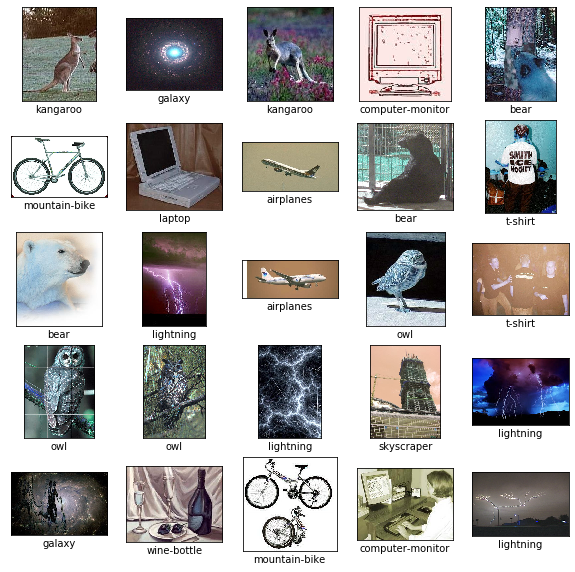

In [15]:
fig = plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])
    plt.xlabel(classes[y[idx]])

plt.show()

### Plot labels distribution for Training and Validation sets

We ensure distribution of datasets to be equal in order to get accurate validation results that reflects the challenge leaderbord score.

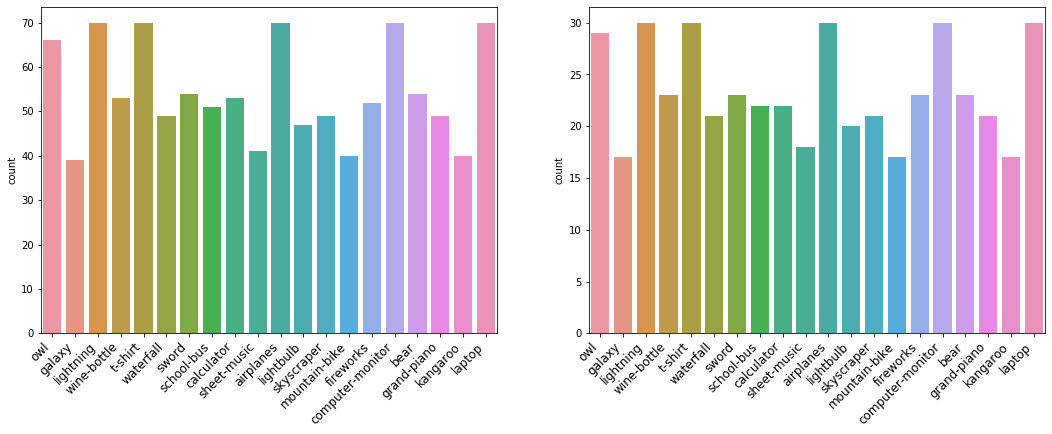

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

hist = sn.countplot(x=y, ax=ax[0])
hist.set_xticklabels(classes, rotation=45, ha="right", fontsize='large')

hist = sn.countplot(x=y_val, ax=ax[1])
hist.set_xticklabels(classes, rotation=45, ha="right", fontsize='large')

plt.show()

## Image Preprocessing

We reshape each image to have shape $380x380$ (default model input shape).

We tried several reshaping methods:
* squashing the images to the desired shape (only resize 380x380)
* padded the original image to be square (adding black borders) for avoiding dimension squashing + resize 380x380
* center crop to 380x380 + padding

The latter method seems to be the best and further fine tuning suggests that ``` padding = 16px ``` is the best choice.



In [0]:
if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, 380, 380) #B4
else:
    input_shape = (380, 380, 3) #B4

#(300, 300, 3) #B3
#(260, 260, 3) #B2
#(240, 240, 3) #B1 
#(224, 224, 3) #B0

In [0]:
def preprocess_input(images, input_shape, crop_padding=16):
    resized = []
    
    if tf.keras.backend.image_data_format() == 'channels_first':
        image_size = input_shape[-1]
    else:    
        image_size = input_shape[0]
    
    for img in images:
        
        h, w = img.shape[:2]

        padded_center_crop_size = int((image_size / \
                                  (image_size + crop_padding)) * min(h, w))
        offset_height = ((h - padded_center_crop_size) + 1) // 2
        offset_width = ((w - padded_center_crop_size) + 1) // 2

        image_crop = img[
                        offset_height: padded_center_crop_size + offset_height,
                        offset_width: padded_center_crop_size + offset_width
                    ]

        img = cv2.resize(image_crop,
              (input_shape[0], input_shape[1]))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        resized.append(img)

    return resized

X = preprocess_input(X, input_shape)
X_val = preprocess_input(X_val, input_shape)

### Plot images after preprocessing

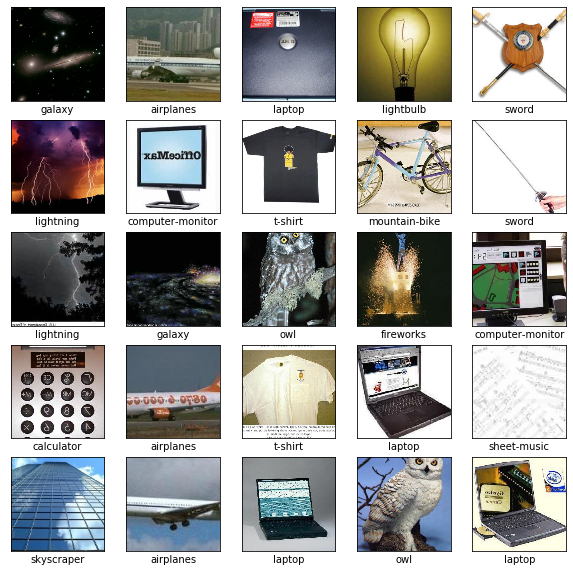

In [19]:
fig = plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])
    plt.xlabel(classes[y[idx]])

plt.show()

## Image Data Generator

We implemented a custom data generator implementing ```tensorflow.keras.utils.Sequence```.
This class is a thread safe data generator provided by tensorflow that allows to use multiprocessing when training the model by using ```model.fit_generator(..., use_multiprocessing=True, workers=n_cpu, ...)```.
In this way the custom generator is used in parallel by ```n_cpu```
 (that is 4 in our case) to generate different batches of images to be fed to the GPU for the training. This allows us to maximize both CPU and GPU usage reducing the idle time they will wait if multiprocessing is not used (for checking: ```htop```
 and ```nvidia-smi``` from command line). 

Notice that we use ```n_cpu=multiprocessing.cpu_count()```, thus manual changing the number of cpu (if more or less than the 4 available on kaggle/colab) is not needed.

The implementation is quite simple as it only needs that ```__len__()```, ```,__getitem__(index)```, and ```on_epoch_end()``` methods being implemented; the first 2 respectively returns the number of batches of the data generator (the number of steps per epoch) and a batch given its index. The last method is essentially used to shuffle all the data when each epoch ends.

We used ```imgaug``` for image augmentation, trying several augmentations; the best ones (and thus the one we used) are horizontal flipping, random crops, random rotations and gaussian blur. We also tried vertical flipping (bad), dropout of some pixels in the image (black squares on the image), elastic transformations, using superpixels representations, some edge detection technique (also sharpening/embossing) but they all seems to give no real improvement and as they are computational expensive we decided to not include them.

Furthermore, we tried different data normalization techniques:

* rescaling values in range $[0,1]$ $\left(\frac{x}{255}\right)$
* rescaling values in range $[-1,1]$, that is the standard tensorflow preprocessing for efficientnet pretrained on imagenet $\left(\frac{x}{127.5} - 1.0 \right)$
* rescaling values to have mean $\mu=0$ and standard deviation $\sigma=1.0$ $\left(\frac{x - \mu}{\sigma}\right)$

The latter seems to give the best improvement thus is the one we adopted.

In [0]:
def normalize_input(img):
    
    img = img.astype('float32')
    
    #Normalize by mean and std deviation

    img = (img - img.mean()) / (img.std())
    
    #Normalize as for ImageNet
    
    #mean = [103.939, 116.779, 123.68]
    #img[..., 0] -= mean[0]
    #img[..., 1] -= mean[1]
    #img[..., 2] -= mean[2]

    #Normalize by scaling values in [-1,+1]

    #img /= 127.5
    #img -= 1.

    if tf.keras.backend.image_data_format() == 'channels_first':
        img = np.rollaxis(img, 2, 0)
        
    return img

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 images,
                 labels,
                 num_classes,
                 batch_size,
                 input_shape,
                 shuffle=False,
                 augment=[],
                 n_augmentations=2):
        
        self.input_shape = input_shape
            
        self.original_images = images
        self.original_labels = labels

        self.num_classes = num_classes
        
        self.batch_size = batch_size
        
        self.shuffle = shuffle
        self.augment = augment
        
        self.epoch = 0
        
        self.images = np.array(self.original_images)
        self.labels = np.array(self.original_labels)
        
        augmenters = []
        
        if 'flip' in self.augment:
            augmenters.append(iaa.Fliplr(.4))
            #augmenters.append(iaa.Flipud(.1))
            
        if 'crop' in self.augment:
            augmenters.append(iaa.Sometimes(0.4,
                                  iaa.CropAndPad(percent=(-0.15, -0.05),
                                                 pad_mode=ia.ALL,
                                                 pad_cval=(0, 255))))
        
        if 'transform' in self.augment:
            transform = iaa.OneOf([
                iaa.Sometimes(.2, iaa.ElasticTransformation(alpha=(0.5, 3.5),
                                                            sigma=0.25)),
                iaa.Sometimes(.1, iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                iaa.Sometimes(.3, iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ])
            augmenters.append(transform)

        if 'edges' in self.augment:
            edges = iaa.OneOf([
                        iaa.SimplexNoiseAlpha(iaa.OneOf([
                            iaa.EdgeDetect(alpha=(0.05, .5)),
                            iaa.DirectedEdgeDetect(alpha=(0.5, 1.0),
                                                   direction=(0.0, 1.0)),
                        ])),
            ])
            augmenters.append(edges)

        if 'blur' in self.augment:
            augmenters.append(iaa.GaussianBlur((0, 1.0)))
            
        if 'dropout' in self.augment:
            drop = iaa.Sometimes(0.3,
                                 iaa.CoarseDropout(p=.1,
                                                   size_percent=(.08, .12),
                                                   per_channel=True))
            augmenters.append(drop)
            
        if 'superpixels' in self.augment:
            s_pix = iaa.Sometimes(0.3,
                                  iaa.Superpixels(
                                    p_replace=(0, 1.0),
                                    n_segments=(20, 200)
                                    )
                                 )
            augmenters.append(s_pix)

        if 'rotate' in self.augment:
            augmenters.append(iaa.Affine(rotate=(-10, 10)))
            
        self.seq = None
        self.n_augmentations = n_augmentations

        if len(augmenters) > 0 and self.n_augmentations > 0:
            self.seq = iaa.Sequential(augmenters, random_order=True)
            for _ in range(self.n_augmentations):
                self.images = np.append(self.images, self.original_images)\
                                .reshape(-1, *self.input_shape)
                self.labels = np.append(self.labels, self.original_labels)\
                                .reshape(-1, self.num_classes)
            
        self.on_epoch_end()
        
    def on_epoch_end(self):
        
        self.epoch += 1

        if self.shuffle == True:
            seed = self.batch_size * self.epoch
                        
            self.images, self.labels = sklearn_shuffle(self.images,
                                                       self.labels,
                                                       random_state=seed)
            
        self.n = self.__len__()
        gc.collect()

    def __len__(self):
        #in tensorflow docs ceil is used, but we found to be better using floor
        #return int(np.ceil(self.images.shape[0] / self.batch_size)) #add 4 total-black images (with class 0 = 'owl'!)
        return int(np.floor(self.images.shape[0] / self.batch_size)) #looses 4 images
        
    def __getitem__(self, step):
        current_images = self.images[step * self.batch_size : \
                              (step + 1) * self.batch_size]

        current_labels = self.labels[step * self.batch_size : \
                                    (step + 1) * self.batch_size]

        X, y = self.__generate_batch(current_images, current_labels, step)
        
        return X, y
    
    def __generate_batch(self, images, labels, step):
        X = np.zeros((self.batch_size, *self.input_shape))
        y = np.zeros((self.batch_size, self.num_classes))

        if self.seq is not None:
            if step >= self.n//self.n_augmentations:
                seq_det = self.seq.to_deterministic()
                images = seq_det.augment_images(images=images)

        for idx, img in enumerate(images):
            img = normalize_input(img)
            X[idx] = img
            y[idx] = labels[idx]
            
        return X, y

In [21]:
batch_size = 8
all_aug = ['flip',
           'crop',
           #'superpixels',
           'blur',
           'rotate']

augment = all_aug
shuffle = True

one_hot_y = tf.keras.utils.to_categorical(y)
one_hot_y_val = tf.keras.utils.to_categorical(y_val)

train_generator = DataGenerator(X,
                                one_hot_y,
                                num_classes=n_classes,
                                batch_size=batch_size,
                                input_shape=input_shape,
                                augment=augment,
                                shuffle=shuffle)

validation_generator = DataGenerator(X_val,
                                     one_hot_y_val,
                                     num_classes=n_classes,
                                     batch_size=batch_size,
                                     input_shape=input_shape)

print("(%dx) Augmented images from %d batches (%d images) to %d batches (%d images)" % \
      (train_generator.n_augmentations, \
       len(X)//train_generator.batch_size, len(X), \
       train_generator.n, train_generator.n * train_generator.batch_size))

(2x) Augmented images from 135 batches (1087 images) to 407 batches (3256 images)


### Show Augmented Images

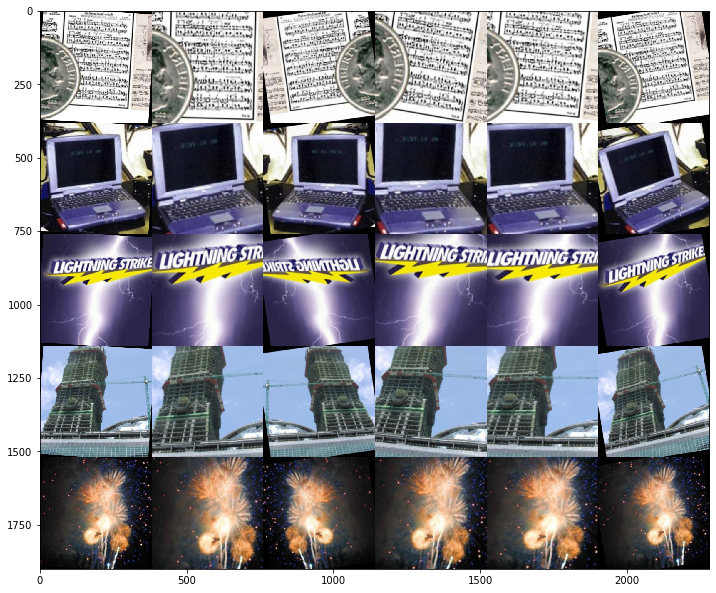

In [22]:
grid = train_generator.seq.to_deterministic().draw_grid(X[:5], 1, 6)

plt.figure(figsize=(12,12))
plt.imshow(np.uint8(grid))
plt.show()

## TL;DR

We trained several models (custom CNNs trained from scratch and different pre-trained models). We do not deliver all the notebooks we wrote as they will be at least 10 only for the pretrained models.

Anyway we provide a detailed description of our work in the next cell toghether with (leaderboard) results for each model we used, that is at all a general summary on how we approached the problem of choosing the model for this challenge.

Furthermore, we include details for using different models and some more detailed explaination on the rationale behind the final model we selected.

For the model selection, we started with simple models with few parameters, 1,2 or 3 simple convolutional blocks $[CONV->RELU->POOL]$, 1, 2 or 3 fully connected layers, changed the number of filters and neurons. We finally came up with a CNN with 4 simple convolution-pooling blocks with 2 fully connected layers on top before the softmax. This model reaches $99\%$ training accuracy and around $60\%$ test accuracy in $150/200$ epochs with proper dropout and augmentation settings. We refined this model also looking to pretrained models used on ImageNet (e.g. VGG architecture) and started to increase model complexity: we moved to more complex convolutional blocks modifying the last 2 adding one more convolutional layer (i.e. $[CONV->RELU->CONV->RELU->POOL]$). This model combined with batch normalization and dropout ($[CONV->BN->RELU->DROPOUT]$) further improves the performances reaching a test accuracy around $70\%$. This is the maximum score we reached with a custom CNN trained from scratch.

Results substantially improves when moving to other techniques such as transfer learning. Also for this methodology we started simple, doing transfer learning using as convolutional base (i.e. convolutional layers of a pretrained model onto another set of classes) first VGG16. As already said, transfer learning is really effective for reaching high scores indeed VGG16 with 2 fully connected layers (1024 neurons each) on top with some little hyperparameter optimization and random augmentation reaches $86-90\%$ test accuracy. Further fine tuning of hyperparameters, properly setting augmentation $[horizontal flips, random rotations, random crops]$, adding batch normalization and $20\%$ dropout reaches $94-95\%$ test accuracy. The overfitting is much smaller with respect to using a model trained from scratch as with transfer learning we use a convolutional base pretrained on ImageNet dataset that is similar to the one given for the challenge.

Given these results we further tried to tune VGG16 unfreezing the last and then the last two convolutional blocks, with no improvement at all. We tried to use the same preprocessing for VGG16 trained on ImageNet and other preprocessing thecniques, progressive resizing, changed input range values (i.e. change data normalization), all with no substantial improvement to be worth the change. Then we moved to more complex CNN architectures.

Besides VGG16, we also tried VGG19, DenseNet121, ResNet50, MobileNet and EfficientNet-B0. Among those, the best models (reaching an accuracy of ~ $96\%$) are DenseNet121, MobileNet and EfficientNet-B0; VGG19 does not performs better than VGG16 (same hyperparameters, $93.8\%$ test accuracy) while ResNet50 seems to perform poorly w.r.t. others ($90.2\%$ test accuracy).

We also tried stacking (substantially creating the stack as a model that feed one input image to all the models in the ensemble and then average the softmax output, so 1 input image 1 softmax output) some of those models:

* ensemble VGG16 ($96.2\%$) $+$ MobileNet ($95.4\%$) $\rightarrow$ $97.8\%$

* ensemble VGG16 ($96.2\%$) $+$ MobileNet ($95.4\%$) $+$ DenseNet121 ($97.0\%$) $\rightarrow$ $97.8\%$

Accuracy reported are always the leaderboard score.

We finally decided for EfficientNet [[1]](https://arxiv.org/pdf/1905.11946.pdf) as in the literature and in their paper (and in practice too) it seems a really effective method.

<table border="0">
<tr>
    <td>
    <img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" width="100%" />
    </td>
    <td>
    <img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/flops.png", width="90%" />
    </td>
</tr>
</table>

The idea behind EfficientNet is that they adopt a different scaling for images, expanding them both in width and in height:

<img src="https://miro.medium.com/max/2022/1*xQCVt1tFWe7XNWVEmC6hGQ.png" width="100%" />

The one proposed in the EfficientNet paper and proven to be effective also on other models is the compound scaling (e) in figure. The main difference between the one proposed and already existing method (scaling one dimension at time height, width and resolution) is that the proposed scaling rescale all the dimesions together with a set of fixed coefficients. This allows both to reach higher accuracies, but also to reduce numbers of FLOPS needed by the network to reach high accuracies w.r.t. state-of-the-art on ImageNet dataset (fig 1.2).

$depth = \alpha^\phi$

$widht = \beta^\phi$

$resolution = \gamma^\phi$

s.t.

$\alpha \cdot \beta^2 \cdot \gamma^2 \approx 2$

$\alpha \geq 1, \beta \geq 1, \gamma \geq 1$

where different values of $\phi$ (fixed) produces different models from B0 ($\phi=1$) to B7.

EfficientNet also includes so called autoaugment policies [[2]](https://arxiv.org/pdf/1805.09501.pdf), that is the network learns also the best augmentation policy to use for augmenting images while training.

**SIDE NOTE:**

The very difference in the code for using different pre-trained models is changing one line in the function that builds the model, e.g. for using ResNet50:

from:
```
base = EfficientNetB4(weights='imagenet',
                      include_top=False,
                      input_shape=input_shape)
```
to:

```
base = tf.keras.applications.ResNet50(weights='imagenet',
                                      include_top=False,
                                      input_shape=input_shape)
```

## Model

The model we choose is EfficientNet-B0 pretrained on ImageNet and re-trained on this dataset. We only add dropout to the top convolutional layer (from the convolutional base), then a Global Average Pooling (GAP) layer and then the classifier on top. As the classification problem is a multi-label classification, we use Softmax as activation function for the last fully connected (dense) layer.

For regularization (excluding data augmentation), we use only dropout for the top convolutional block because all the others already have dropout (increasing when the model complexity increases from $20\%$ for B0 to $40\%$ for B7 as stated in the paper).

We first started freezing all the layers and training only the classifier (test accuracy of $97.4\%$) and iteratively unfrozen convolutional blocks starting from the last to the first. Finally, we decided to retrain the whole model (i.e. unfreeze alla layers) on the dataset and it seems to further improve performances.

### Hyperparameters
We use the following hyperparameters:

* batch size: 8
* optimizer: Adam (default keras $\beta_1=0.9$, $\beta_2=0.999$)
* learning rate: 0.000125
* dropout (for convolutional layer before GAP): $50\%$
* augmentation: random horizontal flip $40\%$ of the images, random crops $40\%$ of the images between $(-0.15, -0.05)\%$ of the original size (sort of little zoom), random rotations between (-10, 10) degrees and gaussian blur with $\sigma=1.0$.

As also said in the EfficientNet paper, increasing the resolution factor is useful when the accuracy fastly saturates after few epochs (as in our case), indeed when increasing the model size (and thuse height, width and resolution accordingly to formulas defined in the paper) we get higher score. We report here our result with different EfficientNet versions (all trained with the same hyperparameters for $10$ epochs):
* EfficientNetB0 $\left(224x224\right)$: loss=$0.110$, val_acc=$97.44\%$, lb_acc=$97.4\%$

* EfficientNetB1 $\left(240x240\right)$: loss=$0.084$, val_acc=$98.06\%$, lb_acc=$97.8\%$

* EfficientNetB2 $\left(260x260\right)$: loss=$0.059$, val_acc=$98.49\%$, lb_acc=$98.4\%$

* EfficientNetB3 $\left(300x300\right)$: loss=$0.051$, val_acc=$98.49\%$, lb_acc=$98.4\%$

* EfficientNetB4 $\left(380x380\right)$: loss=$0.032$, val_acc=$99.14\%$, lb_acc=$99.0\%$

Increasing the model size also implies increasing the input shape (reported in brackets for each model) and thus time needed for train substantially increases (B0 33s/epoch, B4 10min/epoch).
We stopped to B4 as it needs 10min/epoch (~0.125s/image) and increasing of the input shape should not give substantial improvement (following figure 1.1) that are worth to further change the model size. Probably using B5 or B6 will allow us to get some more (even if very small) improvement and probably advance from 3rd position in the leaderboard, but we select EfficientNetB4 as it gives the best trade-off accuracy/time ($99.0\%$ test accuracy, 10 min per epoch). We train the model for $15$ epochs with a learning rate annealer and early stopping.

In [0]:
def build_pretrained_effnet(n_classes,
                            input_shape,
                            learning_rate=1e-4,
                            opt='adam',
                            n_fc=0, 
                            fc_size=1024,
                            dropout=None,
                            weights=None,
                            freeze=None):
      
    base = EfficientNetB4(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)
                  
    if freeze is None:
        freeze = len(base.layers)
        
    for layer in base.layers[:freeze]:
        layer.trainable = False

    out = base.output

    if n_fc > 0:
        out = tf.keras.layers.Flatten()(out)

        for _ in range(n_fc):
            out = tf.keras.layers.Dense(fc_size)(out)
            #out = tf.keras.layers.BatchNormalization(momentum=.99)(out)
            out = tf.keras.layers.Activation('relu')(out)
            if dropout is not None:
                out = tf.keras.layers.Dropout(dropout)(out)

    else:
        if dropout is not None:
            out = tf.keras.layers.Dropout(dropout,
                                          name='top_dropout')(out)

        out = tf.keras.layers.GlobalAveragePooling2D(name='gap')(out)

    out = tf.keras.layers.Dense(n_classes,
                                name='probabilities')(out)
    out = tf.keras.layers.Activation('softmax',
                                     name='softmax',
                                     dtype='float32')(out)

    model = tf.keras.models.Model(inputs=base.input, outputs=out)
    
    model._name = base._name

    if weights is not None:
        model.load_weights(weights)

    optimizers = {
        'adam' : tf.keras.optimizers.Adam,
        'nadam' : tf.keras.optimizers.Nadam,
        'sgd' : tf.keras.optimizers.SGD,
        'rmsprop' : tf.keras.optimizers.RMSprop
    }

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers[opt](lr=learning_rate),
                  metrics=['accuracy'])
        
    return model

In [24]:
learning_rate = 1.25e-4
min_lr = 1e-6

dropout = .5

#single_block = 15
#last_conv = 13

#top = 3
#block_7_a = last_conv
#block_6 = last_conv + 3 * single_block
#block_5 = last_conv + 2 * single_block
#block_4 = last_conv + 2 * single_block

freeze = 0
#freeze -= top 
#freeze -= block_7_a
#freeze -= block_6
#freeze -= block_5
#freeze -= block_4

model = build_pretrained_effnet(n_classes=n_classes,
                                input_shape=input_shape,
                                learning_rate=learning_rate,
                                dropout=dropout,
                                freeze=freeze)

model.summary()

71892992/71892840 [==============================] - 8s 0us/step
Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
___________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.715327 to fit



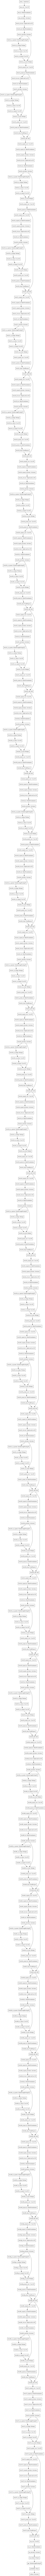

In [25]:
tf.keras.utils.plot_model(model)

In [26]:
trainable_layers = []
for layer in  model.layers:
    if layer.trainable == False:
        pass
    else:
        trainable_layers.append(layer._name)

print("Found %d trainable layers belonging to the following blocks:" % len(trainable_layers),\
      list(np.unique([name.split("_")[0] for name in trainable_layers])))

Found 471 trainable layers belonging to the following blocks: ['block1a', 'block1b', 'block2a', 'block2b', 'block2c', 'block2d', 'block3a', 'block3b', 'block3c', 'block3d', 'block4a', 'block4b', 'block4c', 'block4d', 'block4e', 'block4f', 'block5a', 'block5b', 'block5c', 'block5d', 'block5e', 'block5f', 'block6a', 'block6b', 'block6c', 'block6d', 'block6e', 'block6f', 'block6g', 'block6h', 'block7a', 'block7b', 'gap', 'input', 'probabilities', 'softmax', 'stem', 'top']


## Train the Model

As said before, for training we include a learning rate annealer that decreases the learning rate of factor $r = \frac{1}{2}$ each time the validation loss does not decrease for 1 epoch. Furthermore, we use early stopping to prevent overfitting (if so) stopping the training if the validation loss does not improve for at most 5 epochs.

The learning rate annealer seems to give to the network a little improvement when traning/validation losses starts diverging and allowing to reach lower losses.

In [0]:
sess = tf.keras.backend.get_session()

In [0]:
%%capture

training_enqueuer = tf.keras.utils.OrderedEnqueuer(train_generator,
                                                   use_multiprocessing=True,
                                                   shuffle=False)

training_enqueuer.start(workers=mp.cpu_count())

next(training_enqueuer.get())

In [29]:
epochs = 15

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min', 
                                              patience=5,
                                              verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('weights.h5',
                                                monitor='val_acc',
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode="min",
                                                 min_lr=min_lr,
                                                 factor=.5,
                                                 patience=1,
                                                 verbose=1)

callbacks = [reduce_lr, early_stop, checkpoint]

score = model.fit_generator(train_generator,
                            steps_per_epoch=train_generator.n,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=validation_generator.n,
                            verbose=1,
                            callbacks=callbacks,
                            use_multiprocessing=True,
                            max_queue_size=2 * mp.cpu_count(),
                            workers=mp.cpu_count())

Epoch 1/15
406/407 [============================>.] - ETA: 1s - loss: 0.7580 - acc: 0.8516
Epoch 00001: val_loss improved from inf to 0.09417, saving model to weights.h5
407/407 [==============================] - 697s 2s/step - loss: 0.7563 - acc: 0.8520 - val_loss: 0.0942 - val_acc: 0.9892
Epoch 2/15
406/407 [============================>.] - ETA: 1s - loss: 0.1274 - acc: 0.9741
Epoch 00002: val_loss improved from 0.09417 to 0.05507, saving model to weights.h5
407/407 [==============================] - 557s 1s/step - loss: 0.1285 - acc: 0.9739 - val_loss: 0.0551 - val_acc: 0.9871
Epoch 3/15
406/407 [============================>.] - ETA: 1s - loss: 0.0698 - acc: 0.9837
Epoch 00003: val_loss improved from 0.05507 to 0.03482, saving model to weights.h5
407/407 [==============================] - 557s 1s/step - loss: 0.0697 - acc: 0.9837 - val_loss: 0.0348 - val_acc: 0.9957
Epoch 4/15
406/407 [============================>.] - ETA: 1s - loss: 0.0432 - acc: 0.9892
Epoch 00004: ReduceLROnPl

### Results

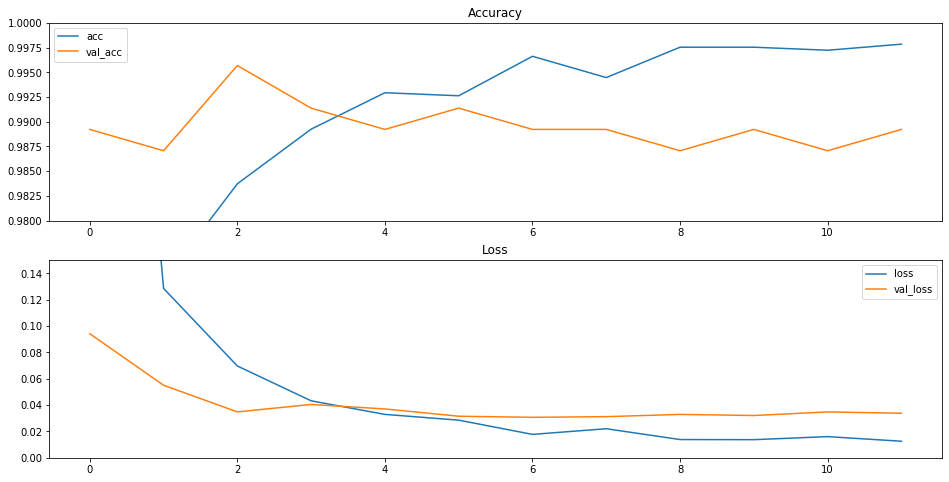

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))

acc = score.history['acc']
ax[0].plot(range(len(acc)), acc, label="acc")

acc = score.history['val_acc']
ax[0].plot(range(len(acc)), acc, label="val_acc")

ax[0].legend()
ax[0].set_title("Accuracy")
ax[0].set_ylim([.98, 1.])

loss = score.history['loss']
ax[1].plot(range(len(loss)), loss, label="loss")

loss = score.history['val_loss']
ax[1].plot(range(len(loss)), loss, label="val_loss")

ax[1].legend()
ax[1].set_title("Loss")
ax[1].set_ylim([.0, .15])

plt.show()

In [0]:
model.load_weights('weights.h5')

In [32]:
loss, accuracy = model.evaluate_generator(validation_generator,
                                          use_multiprocessing=True,
                                          workers=mp.cpu_count())

print("Validation Loss: %.4f" % (loss))
print("Validation Accuracy: {}%".format(np.round(accuracy * 100, 2)))

Validation Loss: 0.0307
Validation Accuracy: 98.92%


## Predictions on Test Data

We also tried Test Time Agumentatio (TTA) in order to improve the leaderboard score with no effect.

Thus, in the end we did not used any TTA (we only tried flips and rotatios with no improvement).

In [0]:
test_dir = input_dir + "test/"

X_test = [cv2.imread(test_dir + img) for img in os.listdir(test_dir)]
X_test = preprocess_input(X_test, input_shape)
y_test = np.zeros(len(X_test))

In [0]:
def augment_images(images):
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-10, 10)),
        iaa.Fliplr(.4)
    ], random_order=True)
    
    seq = seq.to_deterministic()
    images = seq.augment_images(images)
    return images

class TTADataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 images,
                 labels,
                 num_classes,
                 batch_size,
                 input_shape,
                 augment=False):
        
        self.input_shape = input_shape
            
        self.original_images = images
        self.original_labels = labels

        self.num_classes = num_classes
        
        self.batch_size = batch_size
        
        self.augment = augment
        
        self.epoch = 0
            
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.images = np.array(self.original_images)
        self.labels = np.array(self.original_labels)
        self.n = self.__len__()
        self.epoch += 1

    def __len__(self):
        return int(np.ceil(self.images.shape[0] / self.batch_size))
        
    def __getitem__(self, step):
        current_images = self.images[step * self.batch_size : \
                               (step + 1) * self.batch_size]

        current_labels = self.labels[step * self.batch_size : \
                                     (step + 1) * self.batch_size]

        X, y = self.__generate_batch(current_images, current_labels)
        return X, y
    
    def __generate_batch(self, images, labels):
        X = np.zeros((self.batch_size, *self.input_shape))
        y = np.zeros((self.batch_size, self.num_classes))
        
        if self.augment==True:
            images = augment_images(images)

        for idx, img in enumerate(images):
            img = normalize_input(img)
            X[idx] = img
            y[idx] = labels[idx]
            
        return X, y

In [0]:
model.load_weights('weights.h5')

In [36]:
test_generator = TTADataGenerator(X_test,
                                  tf.keras.utils.to_categorical(y_test),
                                  num_classes=n_classes,
                                  batch_size=1,
                                  input_shape=input_shape)

predictions = model.predict_generator(test_generator,
                                      verbose=1,
                                      use_multiprocessing=True,
                                      workers=mp.cpu_count())

predictions = np.argmax(predictions, axis=1)

500/500 [==============================] - 37s 74ms/step


### Create submission file and submit

In [0]:
def create_csv(results, results_dir='./', csv_fname='submission.csv'):
    
    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')
            
image_filenames = next(os.walk(test_dir))[2]

results = {}
for idx, image_name in enumerate(image_filenames):
    results[image_name] = predictions[idx]

csv_fname = 'effnetb4-submission.csv'           
create_csv(results, csv_fname=csv_fname)

In [38]:
submission = pd.read_csv(csv_fname)
submission.head()

Id  Category
0     IMG_0.jpg        12
1  IMG_1001.jpg        16
2  IMG_1007.jpg        14
3  IMG_1011.jpg        15
4  IMG_1023.jpg         0

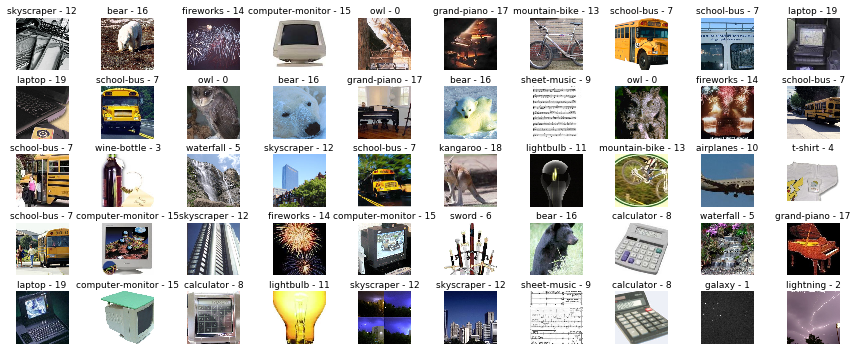

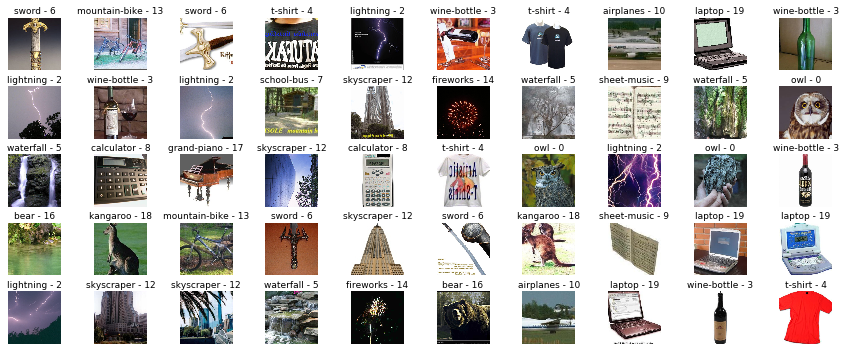

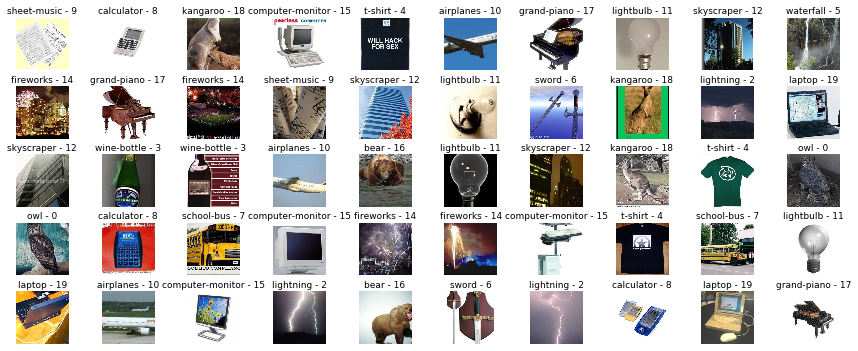

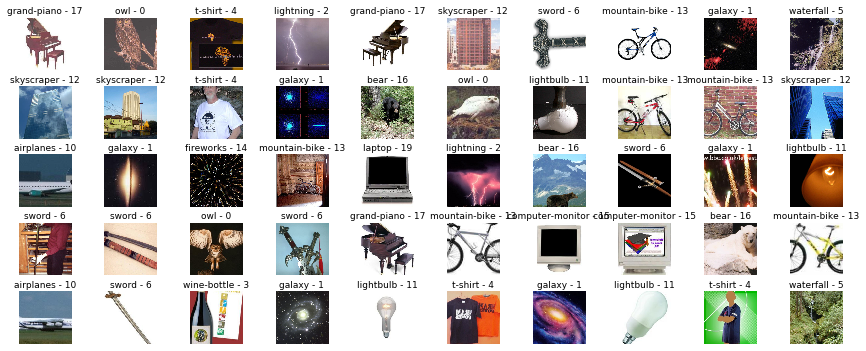

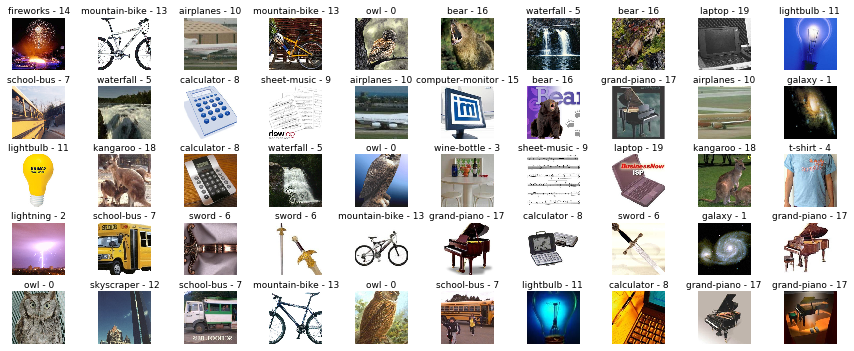

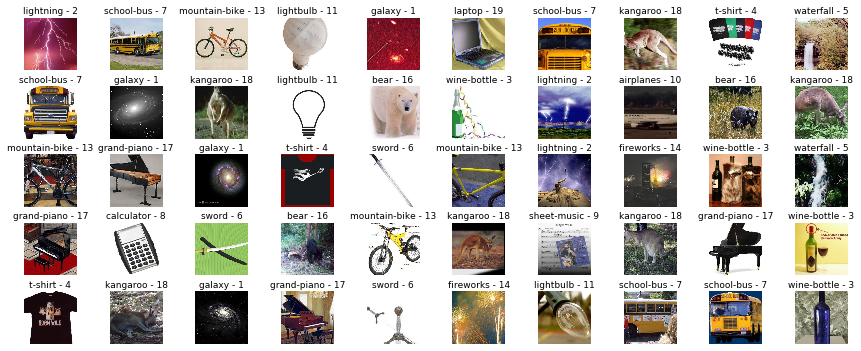

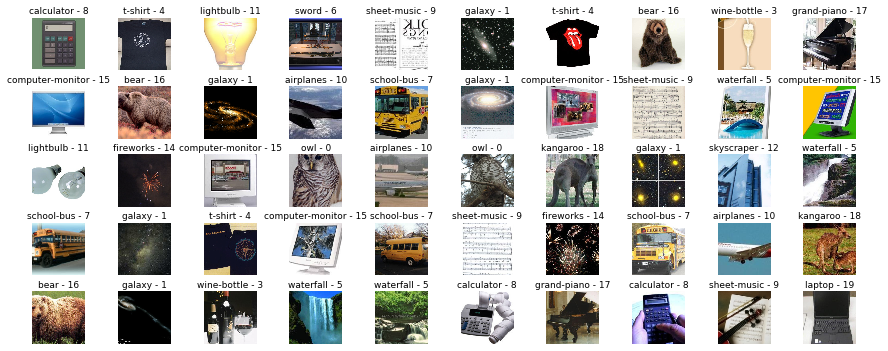

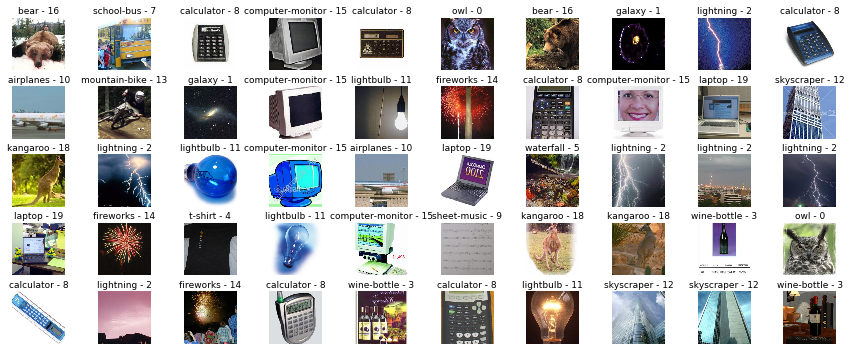

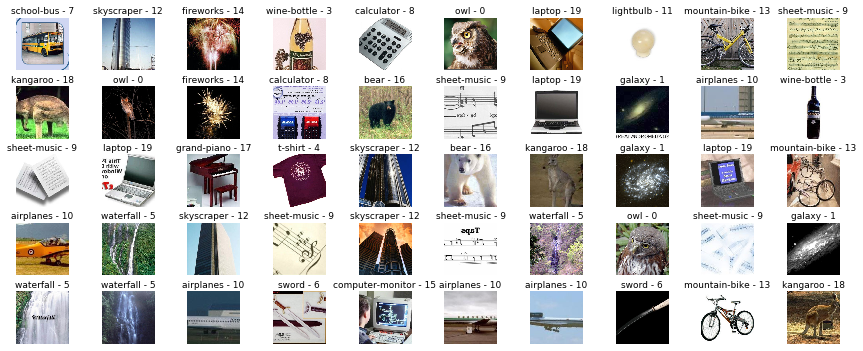

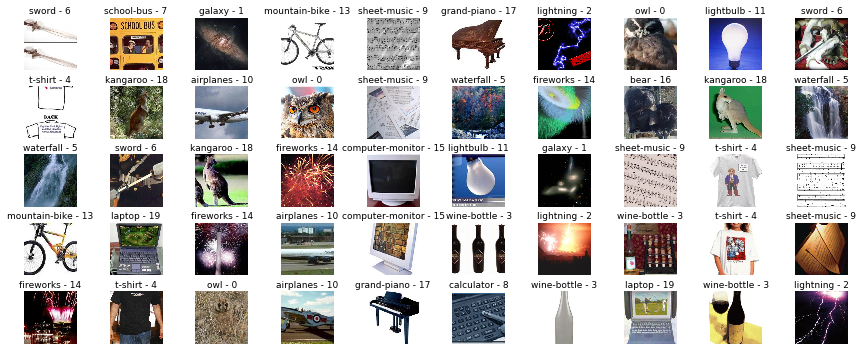

In [39]:
for j in range(500//50):
    plt.figure(figsize=(15,6))

    for i in range(50):  
        plt.subplot(5, 10, i+1)
        i += 50 * j
        plt.imshow(X_test[i])
        plt.title("%s - %d" % (classes[predictions[i]], predictions[i]), y=0.97, fontsize=9)
        plt.axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

In [40]:
!kaggle competitions submit -c ann-and-dl-image-classification -f {csv_fname} -m ""

100% 7.30k/7.30k [00:03<00:00, 2.07kB/s]
Successfully submitted to Artificial Neural Networks and Deep Learning